# Objetivos

Desenvolver um modelo de predição utilizando um conjunto de dados que detalha a geração horária de energia elétrica no Brasil, de 2000 a 2018. 

Apesar da granularidade horária dos dados, o modelo deve focar em previsões na frequência mensal. Você tem a liberdade de escolher como agrupar os dados para a previsão - seja por total geral, por tipo de usina, tipo de combustível, região ou estado. Essa escolha deve ser justificada com base na relevância e impacto esperado no resultado da previsão. Para a validação do modelo, utilize os dados correspondentes aos anos de 2019 e 2020

# 1.0. Imports

In [493]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.linear_model  import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score


## 1.1. Funções

In [483]:
# Função para calcular as métricas MAE, MAPE e RMSE de um modelo de ML
def ml_error( model_name, y, y_pred ):
    mae = mean_absolute_error( y, y_pred )
    mape = mean_absolute_percentage_error( y, y_pred )
    rmse = root_mean_squared_error(y, y_pred ) 
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] )


def cross_validation(x, y, k_fold, model_name, model):
    # Assume 'X' is your feature matrix and 'y' is the target variable

    # Choose the number of folds (k)
    k_folds = k_fold

    # Initialize the model (replace with your model)
    model = model

    # Create a k-fold cross-validation object
    kf = KFold(n_splits=k_folds, shuffle=True)

    # Perform cross-validation and get performance scores
    mae = -cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_error').mean()
    mape = -cross_val_score(model, x, y, cv=kf, scoring='neg_mean_absolute_percentage_error').mean()
    rmse = -cross_val_score(model, x, y, cv=kf, scoring='neg_root_mean_squared_error').mean()

    return pd.DataFrame({ 'Model Name' : model_name,
                          'MAE' : mae,
                          'MAPE' : mape,
                          'RMSE' : rmse}, index=[0])

# 2.0. Loading Data

In [5]:
# Carregando os arquivos csv em um único dataframe
anos = list(range(2000, 2019))
df = pd.DataFrame()
for ano in anos:
    aux = pd.read_csv('GERACAO_USINA_'+str(ano)+'.csv', sep=';')
    df = pd.concat([df,aux], ignore_index=True)


In [6]:
# Vamos carregar também os dados que serão usados para a validação do modelo de predição
df_val2019 = pd.read_csv('GERACAO_USINA_2019.csv', sep=';')
df_val2020 = pd.read_csv('GERACAO_USINA_2020.csv', sep=';')
df_val = pd.concat([df_val2019, df_val2020], ignore_index=True)

In [3]:
# Observando comportamento geral
display(df.head())
display(df.tail())

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.5,NaN
1,2000-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.6,NaN
2,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.0,NaN
3,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.5,NaN
4,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.8,NaN


,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
45461852,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Colorado,UTE.AI.SP.028094-1.01,21.000,NaN
45461853,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guarani Cruz Alta,UTE.AI.SP.027796-7.01,13.000,NaN
45461854,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,119.600,NaN
45461855,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,476.403,NaN
45461856,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,301.851,NaN


In [103]:
# Verificando os dados de validação
display(df_val.head())
display(df_val.tail())

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,HIDROELÉTRICA,Hidráulica,Balbina,UHE.PH.AM.000190-2.01,82.993,NaN
1,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO III,TÉRMICA,Óleo Diesel,Flores 4,UTE.PE.AM.029192-7.01,14.032,NaN
2,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Ponta Negra,UTE.GN.AM.029361-0.02,65.343,NaN
3,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO I,TÉRMICA,Gás,Tambaqui,UTE.PE.AM.029276-1.01,50.980,NaN
4,2019-01-01 00:00:00,N,NORTE,AM,AMAZONAS,TIPO III,TÉRMICA,Óleo Combustível,Distrito A,UTE.PE.AM.030273-2.01,0.000,NaN


,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
8873565,2020-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Fartura,UTE.AI.SP.029203-6.01,29.000,SPFART
8873566,2020-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guaíra Energética,UTE.AI.SP.030026-8.01,24.000,SPGUAI
8873567,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,80.430,TOUHSA
8873568,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,310.602,TOLAJ
8873569,2020-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,140.647,TOUHPA


# 3.0. Descrição dos dados

## 3.1. Dimensões

In [10]:
# Dimensão do dataframe
print('Número de linhas: ', '{:,}'.format(df.shape[0]))
print('Número de colunas: ', df.shape[1])

Número de linhas:  45,461,857
Número de colunas:  12


## 3.2. Tipo de dados

In [11]:
df.dtypes

din_instante               object
id_subsistema              object
nom_subsistema             object
id_estado                  object
nom_estado                 object
cod_modalidadeoperacao     object
nom_tipousina              object
nom_tipocombustivel        object
nom_usina                  object
ceg                        object
val_geracao               float64
id_ons                     object
dtype: object

Fora a variável alvo todas as outras variáveis são categóricas

Vamos mudar 'din_instante' para datetime

## 3.3. Verificando dados faltantes

In [6]:
df.isna().sum()

din_instante                     0
id_subsistema                    0
nom_subsistema                   0
id_estado                        0
nom_estado                       0
cod_modalidadeoperacao          24
nom_tipousina                    0
nom_tipocombustivel              0
nom_usina                        0
ceg                              0
val_geracao                 131289
id_ons                    44005178
dtype: int64

## 3.4. Verificando dados únicos das colunas

In [4]:
columns = df.columns
for column in columns:
    print('Dados únicos da coluna: ', column)
    print(df[column].unique())
    print('Quantidade de dados únicos: ', df[column].nunique())
    print('\n')

Dados únicos da coluna:  din_instante
['2000-01-01 00:00:00' '2000-01-01 01:00:00' '2000-01-01 02:00:00' ...
 '2018-12-31 21:00:00' '2018-12-31 22:00:00' '2018-12-31 23:00:00']
Quantidade de dados únicos:  166541


Dados únicos da coluna:  id_subsistema
['N' 'NE' 'S' 'SE']
Quantidade de dados únicos:  4


Dados únicos da coluna:  nom_subsistema
['NORTE' 'NORDESTE' 'SUL' 'SUDESTE' 'PARAGUAI']
Quantidade de dados únicos:  5


Dados únicos da coluna:  id_estado
['PA' 'AL' 'BA' 'PE' 'PI' 'PR' 'RS' 'SC' 'DF' 'ES' 'GO' 'I' 'MG' 'MS' 'MT'
 'RJ' 'SP' 'TO' 'CE' 'PB' 'RN' 'SE' 'RO' 'AC' 'MA' 'AM' 'AP']
Quantidade de dados únicos:  27


Dados únicos da coluna:  nom_estado
['PARA' 'ALAGOAS' 'BAHIA' 'PERNAMBUCO' 'PIAUI' 'PARANA'
 'RIO GRANDE DO SUL' 'SANTA CATARINA' 'DISTRITO FEDERAL' 'ESPIRITO SANTO'
 'GOIAS' 'z - INTERNACIONAL' 'MINAS GERAIS' 'MATO GROSSO DO SUL'
 'MATO GROSSO' 'RIO DE JANEIRO' 'SAO PAULO' 'TOCANTINS' 'CEARA' 'PARAIBA'
 'RIO GRANDE DO NORTE' 'SERGIPE' 'RONDONIA' 'ACRE' 'MARANHAO'

# 4.0. Tratamento e limpeza dos dados

In [7]:
df1 = df.copy()

## 4.1. Lidando com dados faltantes

### 4.1.1 Coluna - val_geracao

In [8]:
# Vamos verificar as linhas sem informaçõo de val_geracao
df1[df1.val_geracao.isna()]

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
5430193,2004-02-15 00:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
5430385,2004-02-15 01:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
5430582,2004-02-15 02:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
5430776,2004-02-15 03:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
5430994,2004-02-15 04:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
45461307,2018-12-31 22:00:00,SE,SUDESTE,SP,SAO PAULO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidrelétricas da Cesp,-,NaN,NaN
45461734,2018-12-31 23:00:00,SE,SUDESTE,MS,MATO GROSSO DO SUL,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Enersul,-,NaN,NaN
45461735,2018-12-31 23:00:00,SE,SUDESTE,MS,MATO GROSSO DO SUL,Conjunto de Usinas,TÉRMICA,Resíduos Industriais,Conj. Fíbria,-,NaN,NaN
45461773,2018-12-31 23:00:00,SE,SUDESTE,RJ,RIO DE JANEIRO,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,PEQUENAS CENTRAIS HIDROELÉTRICAS DA AMPLA,-,NaN,NaN


#### Como não sabemos o motivo desses dados estarem faltando e pelo fato de serem poucos em relação ao total vamos excluí-los

In [9]:
df1.dropna(subset=['val_geracao'], inplace=True)

### 4.1.2. Coluna - id_ons

In [10]:
df1[df1.id_ons.isna()]

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
0,2000-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2422.500,NaN
1,2000-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1995.600,NaN
2,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,13.000,NaN
3,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,202.500,NaN
4,2000-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso II,UHE.PH.BA.027048-2.01,269.800,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
45461852,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Colorado,UTE.AI.SP.028094-1.01,21.000,NaN
45461853,2018-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Guarani Cruz Alta,UTE.AI.SP.027796-7.01,13.000,NaN
45461854,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,São Salvador,UHE.PH.TO.028567-6.01,119.600,NaN
45461855,2018-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,476.403,NaN


In [11]:
df1[df1.id_ons.notna()]

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao,id_ons
8775158,2006-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,4613.86,PATU
8775159,2006-01-01 00:00:00,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Curuá-Una,UHE.PH.PA.027130-6.01,18.00,PACU
8775160,2006-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,2117.14,ALUXG
8775161,2006-01-01 00:00:00,NE,NORDESTE,AL,ALAGOAS,TIPO I,TÉRMICA,Óleo Diesel,Rio Largo Brasympe,UTE.PE.AL.028505-6.01,0.00,ALBERL
8775162,2006-01-01 00:00:00,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Pedra do Cavalo,UHE.PH.BA.028565-0.01,80.58,BAUCV
...,...,...,...,...,...,...,...,...,...,...,...,...
10231832,2006-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO I,TÉRMICA,Gás,Nova Piratininga,UTE.GN.SP.028191-3.01,0.00,SPUNPI
10231833,2006-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO I,TÉRMICA,Óleo Combustível,Carioba,UTE.PE.SP.000678-5.01,0.00,SPUCA
10231834,2006-12-31 23:00:00,SE,SUDESTE,SP,SAO PAULO,TIPO I,TÉRMICA,Gás,Piratininga,UTE.PE.SP.002082-6.01,0.00,SPPI
10231835,2006-12-31 23:00:00,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,302.02,TOUHPA


#### Como aparentemente só temos dados dessa coluna em apenas um ano (2006), não será útil para nossa análise, por isso vamos excluir essa coluna

In [12]:
df1.drop('id_ons', axis=1, inplace=True)

### 4.1.1 Coluna - cod_modalidadeoperacao

In [13]:
df1[df1.cod_modalidadeoperacao.isna()]

,din_instante,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao
4627093,2003-09-01 00:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4627292,2003-09-01 01:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4627493,2003-09-01 02:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4627694,2003-09-01 03:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4627894,2003-09-01 04:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4628093,2003-09-01 05:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4628290,2003-09-01 06:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4628495,2003-09-01 07:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4628694,2003-09-01 08:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0
4628891,2003-09-01 09:00:00,SE,SUDESTE,SP,SAO PAULO,NaN,TÉRMICA,Óleo Combustível,USI Carioba,UTE.PE.SP.000678-5.01,0.0


In [14]:
# df1[df1.ceg == 'UTE.PE.SP.000678-5.01'].nom_usina.unique()

In [15]:
# df1[df1.nom_usina == 'Carioba'].cod_modalidadeoperacao.unique()

In [16]:
# df1.cod_modalidadeoperacao = df1.cod_modalidadeoperacao.fillna('TIPO I')

In [17]:
# df1.loc[df1.nom_usina == 'USI Carioba', 'nom_usina'] = 'Carioba'

#### Por serem apenas 24 dados em um único dia em uma única usina onde não houve geração de energia, podemos excluir essas linhas

In [18]:
df1.dropna(subset=['cod_modalidadeoperacao'], inplace = True)

In [19]:
# Vamos verificar se nos livramos dos dados faltantes
df1.isna().sum()

din_instante              0
id_subsistema             0
nom_subsistema            0
id_estado                 0
nom_estado                0
cod_modalidadeoperacao    0
nom_tipousina             0
nom_tipocombustivel       0
nom_usina                 0
ceg                       0
val_geracao               0
dtype: int64

## 4.2. Transformando em dados mensais

#### Como vamos fazer a análise mensal dos dados, vamos modificar o dataset agrupando-os mensalmente 

In [20]:
df2 = df1.copy()

In [21]:
# Primeiro vamos transformar a coluna din_instante para o formato de data
df2.din_instante = pd.to_datetime(df2.din_instante)

In [22]:
# Agora vamos criar as colunas de ano e mês separadamente
df2['ano'] = df2.din_instante.dt.year
df2['mes'] = df2.din_instante.dt.month

In [23]:
# Com isso podemos agrupar os dados em relação ao Ano e Mês onde adicionais toda a geração de energia mensal
df2 = df2.groupby(['ano', 'mes', 'id_subsistema', 'nom_subsistema', 'id_estado', 'nom_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'nom_tipocombustivel', 'nom_usina', 'ceg']).agg({'val_geracao': 'sum'}).sort_values(['ano', 'mes']).reset_index()

In [24]:
df2

,ano,mes,id_subsistema,nom_subsistema,id_estado,nom_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,nom_usina,ceg,val_geracao
0,2000,1,N,NORTE,PA,PARA,TIPO I,HIDROELÉTRICA,Hidráulica,Tucuruí,UHE.PH.PA.002889-4.01,2459950.900
1,2000,1,NE,NORDESTE,AL,ALAGOAS,TIPO I,HIDROELÉTRICA,Hidráulica,Xingó,UHE.PH.SE.027053-9.01,1577526.800
2,2000,1,NE,NORDESTE,BA,BAHIA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,Pequenas Centrais Hidroelétricas da Chesf,-,21135.500
3,2000,1,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Apolônio Sales,UHE.PH.AL.001510-5.01,144444.200
4,2000,1,NE,NORDESTE,BA,BAHIA,TIPO I,HIDROELÉTRICA,Hidráulica,Paulo Afonso I,UHE.PH.BA.002012-5.01,80098.300
...,...,...,...,...,...,...,...,...,...,...,...,...
62572,2018,12,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,São José Colina,UTE.AI.SP.028975-2.01,0.000
62573,2018,12,SE,SUDESTE,SP,SAO PAULO,TIPO III,TÉRMICA,Biomassa,Vale do Rosário,UTE.AI.SP.002958-0.01,44512.617
62574,2018,12,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Lajeado,UHE.PH.TO.001304-8.01,325305.801
62575,2018,12,SE,SUDESTE,TO,TOCANTINS,TIPO I,HIDROELÉTRICA,Hidráulica,Peixe Angical,UHE.PH.TO.028353-3.01,153460.067


## 4.3. Removendo colunas 

#### Vamos agrupar os dados de modo a descartar as colunas redundantes(como 'id_subsistema' e 'nom_estado') e também colunas que não agregam para a análise dos dados ('nom_usina' e 'ceg')


In [272]:
df3 = df2.groupby(['ano', 'mes', 'nom_subsistema', 'id_estado', 'cod_modalidadeoperacao', 'nom_tipousina', 'nom_tipocombustivel']).agg({'val_geracao': 'sum'}).sort_values(['ano', 'mes']).reset_index()

In [273]:
df3

,ano,mes,nom_subsistema,id_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,val_geracao
0,2000,1,NORDESTE,AL,TIPO I,HIDROELÉTRICA,Hidráulica,1577526.800
1,2000,1,NORDESTE,BA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,21135.500
2,2000,1,NORDESTE,BA,TIPO I,HIDROELÉTRICA,Hidráulica,1672673.400
3,2000,1,NORDESTE,BA,TIPO I,TÉRMICA,Gás,13120.500
4,2000,1,NORDESTE,PE,TIPO I,HIDROELÉTRICA,Hidráulica,626158.400
...,...,...,...,...,...,...,...,...
20613,2018,12,SUL,SC,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,169778.667
20614,2018,12,SUL,SC,TIPO I,HIDROELÉTRICA,Hidráulica,1835371.169
20615,2018,12,SUL,SC,TIPO I,TÉRMICA,Carvão,243666.850
20616,2018,12,SUL,SC,TIPO II-A,TÉRMICA,Biomassa,987.535


# 5.0. Análise de Dados

## 5.1. Análise com a variável alvo (Energia Gerada)

In [27]:
# Vamos começar analisando as estatísticas da nossa variável
df3.val_geracao.describe()

count    2.061800e+04
mean     4.183548e+05
std      1.015044e+06
min      0.000000e+00
25%      8.922675e+02
50%      3.846021e+04
75%      2.304175e+05
max      7.491162e+06
Name: val_geracao, dtype: float64


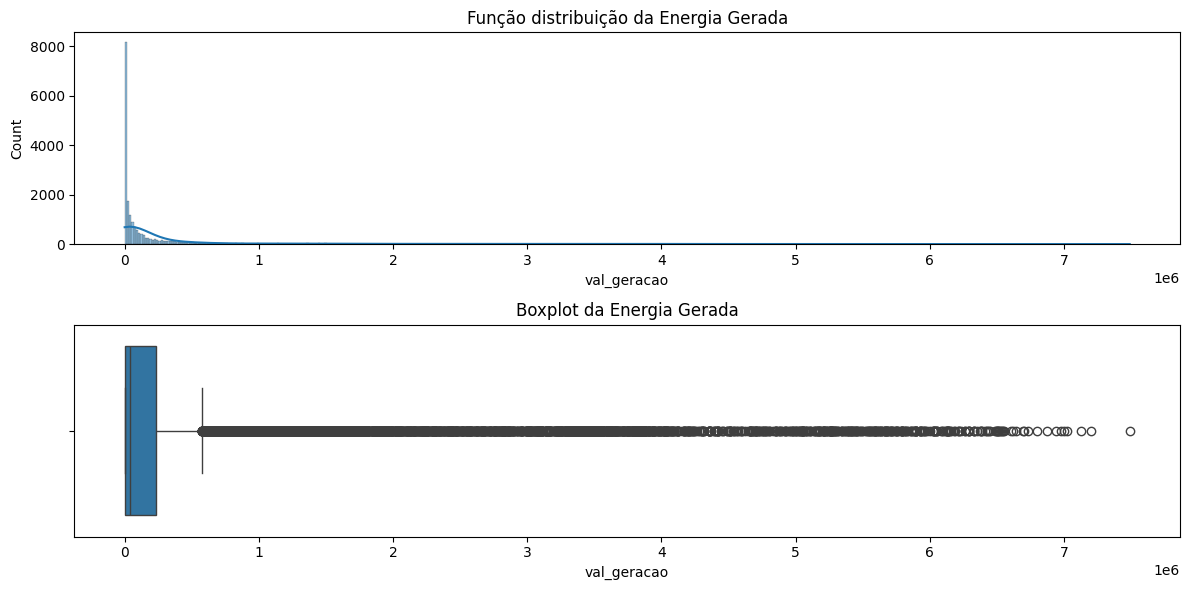

In [139]:
# Vamos analisar o gráfico de distribuição da energia 
fig, axes = plt.subplots(2, 1, figsize=(12, 6))

# Plot a distribution plot on the first subplot
sns.histplot(df3.val_geracao, ax=axes[0], kde=True)
axes[0].set_title('Função distribuição da Energia Gerada')

# Plot a box plot on the second subplot
sns.boxplot(x=df3.val_geracao, ax=axes[1])
axes[1].set_title('Boxplot da Energia Gerada')

plt.tight_layout() # Adjust the layout to make sure there's no overlap
plt.show()

- Notamos muitos outliers, com grandeza de energia muito acima da média.
- Não tem o comportamento de uma distribuição normal dada a assimetria e e cauda longa.

## 5.2. Relação das variáveis com a Energia Gerada

### 5.2.1 Relação Ano x Val_geracao

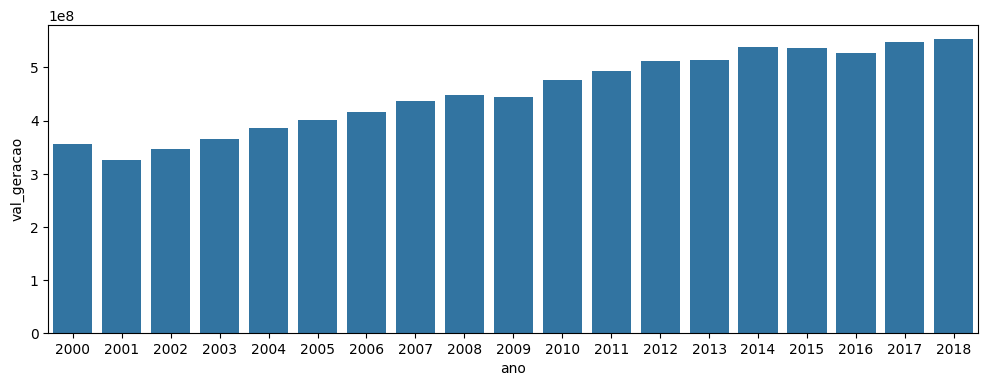

In [41]:
plt.figure(figsize=(12, 4))
sns.barplot(x='ano', y='val_geracao', data=df3, estimator='sum', errorbar=None)
plt.show()

- Podemos observar um aumento gradativo da geração de energia ao longo dos anos o que era esperado

### 5.2.2. Relação Mês x Energia

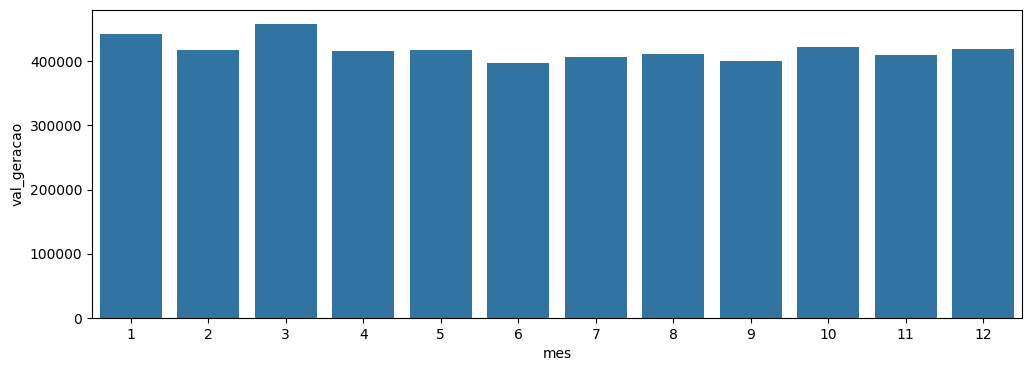

In [43]:
plt.figure(figsize=(12, 4))
sns.barplot(x='mes', y='val_geracao', data=df3, estimator='mean', errorbar=None)
plt.show()

- Neste caso vemos que em média o período de verão (entre dezembro e março) tende a ser um pouco mais alto do que nas outras épocas do ano

### 5.2.3. Relação Região x Energia

In [209]:
def barplot_ordenado(x, y, data, estimator, title=''):
    # Ordenando o gráfico em função de y
    order = data.groupby(x)[y].apply(estimator).sort_values(ascending=False).index
    
    # Barplot
    ax = sns.barplot(x=x, y=y, data=data, estimator=estimator, order=order, errorbar=None)
    
    # Colocando título e removando os labels x e y
    ax.set_title(title)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
    plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
    plt.tight_layout()  # Adjust layout for the current plot
    plt.show()  # Display the plot

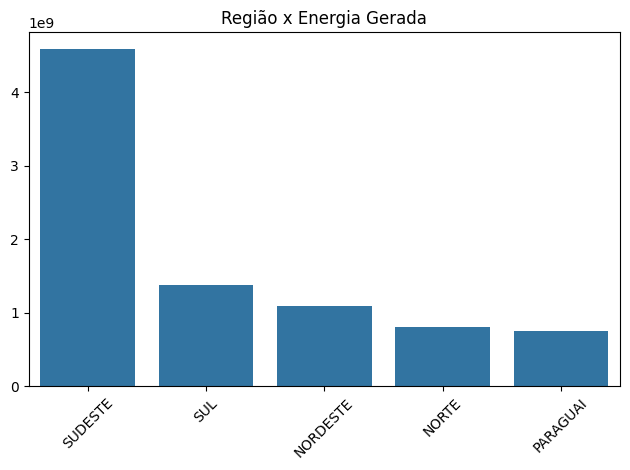

In [133]:
barplot_ordenado('nom_subsistema', 'val_geracao', df3, 'sum', 'Região x Energia Gerada')

- A região Sudeste gerou mais energia do que todas as outras regiões juntas

### 5.2.4. Relação Estado x Energia

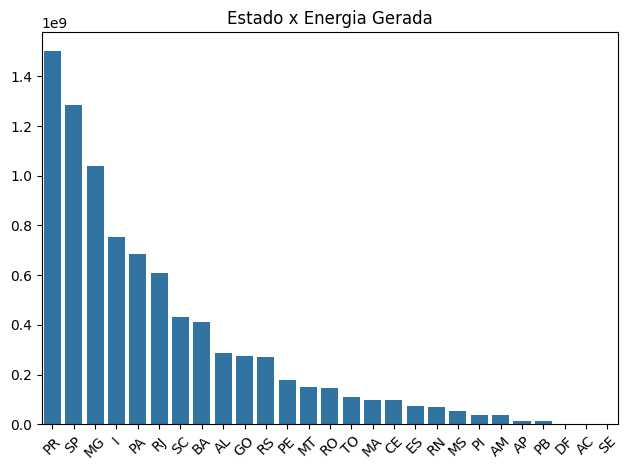

In [134]:
barplot_ordenado('id_estado', 'val_geracao', df3, 'sum', 'Estado x Energia Gerada')

### 5.2.5. Relação Modalidade x Energia

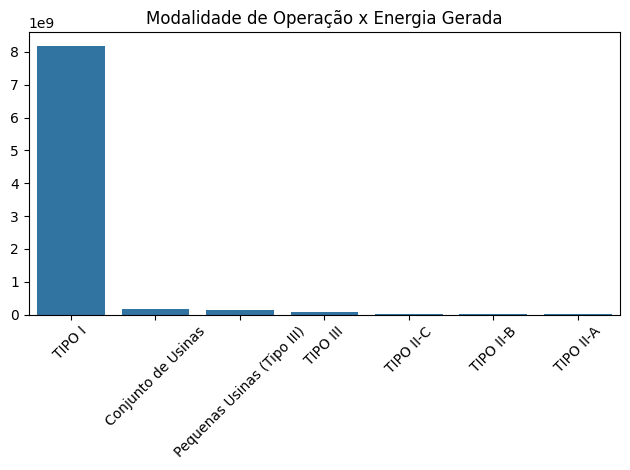

In [135]:
barplot_ordenado('cod_modalidadeoperacao', 'val_geracao', df3, 'sum', 'Modalidade de Operação x Energia Gerada')

### 5.2.6. Relação Tipo de usina x Energia

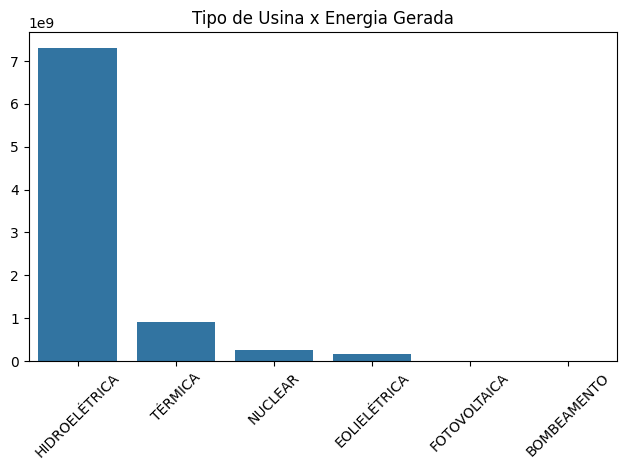

In [136]:
barplot_ordenado('nom_tipousina', 'val_geracao', df3, 'sum', 'Tipo de Usina x Energia Gerada')

### 5.2.7. Relação Tipo de Combustível x Energia

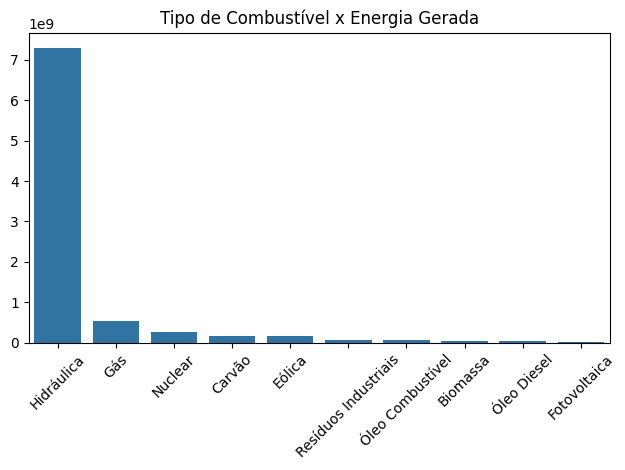

In [137]:
barplot_ordenado('nom_tipocombustivel', 'val_geracao', df3, 'sum', 'Tipo de Combustível x Energia Gerada')

## 5.3. Relação entre as variáveis preditoras

### 5.3.1. Estado x Subsistema

In [336]:
# pd.crosstab(df3['id_estado'], df3['nom_subsistema'])
df3.pivot_table(values='val_geracao', index='id_estado', columns='nom_subsistema', aggfunc='sum', margins=True)

nom_subsistema,NORDESTE,NORTE,PARAGUAI,SUDESTE,SUL,All
id_estado,,,,,,
AC,NaN,NaN,NaN,2.499006e+05,NaN,2.499006e+05
AL,2.869707e+08,NaN,NaN,NaN,NaN,2.869707e+08
AM,NaN,3.735666e+07,NaN,NaN,NaN,3.735666e+07
AP,NaN,1.387671e+07,NaN,NaN,NaN,1.387671e+07
BA,4.125776e+08,NaN,NaN,NaN,NaN,4.125776e+08
CE,9.639219e+07,NaN,NaN,NaN,NaN,9.639219e+07
DF,NaN,NaN,NaN,1.786634e+06,NaN,1.786634e+06
ES,NaN,NaN,NaN,7.319327e+07,NaN,7.319327e+07
GO,NaN,NaN,NaN,2.756814e+08,NaN,2.756814e+08


#### Algo estranho aqui, podemos notar que alguns estados estão em subsistemas que não pertencem a sua região, no entanto aparentemente isso pode ocorrer, portanto vamos deixar os dados como estão. 

#### A região sudeste gera mais energia mas não significa que são geradas apenas nos estados do sudeste em si.

### 5.3.2. Relação entre Modalidade de Operação x Subsistema

In [335]:
# pd.crosstab(df3['cod_modalidadeoperacao'], df3['nom_subsistema'])
df3.pivot_table(values='val_geracao', index='nom_subsistema', columns='cod_modalidadeoperacao', aggfunc='sum', margins=True)

cod_modalidadeoperacao,Conjunto de Usinas,Pequenas Usinas (Tipo III),TIPO I,TIPO II-A,TIPO II-B,TIPO II-C,TIPO III,All
nom_subsistema,,,,,,,,
NORDESTE,1.054563e+08,1.195621e+06,9.572169e+08,2.787739e+06,6.065429e+06,1.645118e+07,3.048454e+06,1.092222e+09
NORTE,1.678581e+06,0.000000e+00,7.994829e+08,NaN,7.855893e+06,NaN,4.234164e+06,8.132515e+08
PARAGUAI,NaN,NaN,7.515773e+08,NaN,NaN,NaN,NaN,7.515773e+08
SUDESTE,2.689524e+07,1.106706e+08,4.380465e+09,2.607168e+06,6.506874e+06,2.559802e+06,5.518773e+07,4.584893e+09
SUL,1.917140e+07,3.644453e+07,1.296015e+09,5.281285e+06,2.695293e+06,1.171403e+07,1.237441e+07,1.383696e+09
All,1.532016e+08,1.483107e+08,8.184758e+09,1.067619e+07,2.312349e+07,3.072501e+07,7.484476e+07,8.625639e+09


#### O Tipo I e a região Sudeste são as que mais produzem energia.

### 5.3.3. Relação entre Tipo de usina x Subsistema

In [334]:
# pd.crosstab(df3['nom_tipousina'], df3['nom_subsistema'], margins=True)
df3.pivot_table(values='val_geracao', index='nom_subsistema', columns='nom_tipousina', aggfunc='sum', margins=True)

nom_tipousina,BOMBEAMENTO,EOLIELÉTRICA,FOTOVOLTAICA,HIDROELÉTRICA,NUCLEAR,TÉRMICA,All
nom_subsistema,,,,,,,
NORDESTE,NaN,1.302360e+08,2273252.645,7.670327e+08,NaN,1.926797e+08,1.092222e+09
NORTE,NaN,1.678581e+06,NaN,7.148877e+08,NaN,9.668517e+07,8.132515e+08
PARAGUAI,NaN,NaN,NaN,7.515773e+08,NaN,NaN,7.515773e+08
SUDESTE,186.992,NaN,1015290.073,3.886571e+09,2.596656e+08,4.376405e+08,4.584893e+09
SUL,NaN,2.610799e+07,NaN,1.184589e+09,NaN,1.729991e+08,1.383696e+09
All,186.992,1.580226e+08,3288542.718,7.304658e+09,2.596656e+08,9.000045e+08,8.625639e+09


#### As usinas Hidroelétricas são as que mais geram energia em todas as regiões, no entanto tambpem podemos observar que as usinas Térmicas, Fotovoltaica e Eolielétrica também contribuem bastante na geração de energia.

### 5.3.4. Relação entre Modalidade de Operação x Tipo de Usina

In [333]:
df3.pivot_table(values='val_geracao', index='cod_modalidadeoperacao', columns='nom_tipousina', aggfunc='sum', margins=True)

nom_tipousina,BOMBEAMENTO,EOLIELÉTRICA,FOTOVOLTAICA,HIDROELÉTRICA,NUCLEAR,TÉRMICA,All
cod_modalidadeoperacao,,,,,,,
Conjunto de Usinas,NaN,1.209928e+08,3157925.004,1.054111e+07,NaN,1.850976e+07,1.532016e+08
Pequenas Usinas (Tipo III),NaN,NaN,NaN,1.387429e+08,NaN,9.567823e+06,1.483107e+08
TIPO I,186.992,9.863271e+06,NaN,7.118667e+09,2.596656e+08,7.965618e+08,8.184758e+09
TIPO II-A,NaN,NaN,NaN,4.864377e+06,NaN,5.811815e+06,1.067619e+07
TIPO II-B,NaN,2.207860e+06,73805.723,4.019751e+05,NaN,2.043985e+07,2.312349e+07
TIPO II-C,NaN,2.330582e+07,56811.991,4.441716e+05,NaN,6.918205e+06,3.072501e+07
TIPO III,NaN,1.652895e+06,NaN,3.099669e+07,NaN,4.219518e+07,7.484476e+07
All,186.992,1.580226e+08,3288542.718,7.304658e+09,2.596656e+08,9.000045e+08,8.625639e+09


#### Vemos que o usinas do tipo I e Hidroelétricas geram a maioria da energia.

# 6.0. Preparação dos dados

In [337]:
df4 = df3.copy()

In [340]:
df4.sample(5)

,ano,mes,nom_subsistema,id_estado,cod_modalidadeoperacao,nom_tipousina,nom_tipocombustivel,val_geracao
6690,2009,3,SUL,RS,TIPO I,TÉRMICA,Gás,0.00
2645,2004,1,NORDESTE,BA,TIPO III,TÉRMICA,Gás,0.00
4609,2006,5,SUDESTE,RJ,TIPO I,TÉRMICA,Gás,435504.53
4135,2005,9,SUL,PR,TIPO I,HIDROELÉTRICA,Hidráulica,3314098.84
6427,2008,12,NORDESTE,BA,Pequenas Usinas (Tipo III),HIDROELÉTRICA,Hidráulica,14880.00


In [343]:
df4['mes_sin'] = np.sin(2 * np.pi * df4['mes']/12)
df4['mes_cos'] = np.cos(2 * np.pi * df4['mes']/12)

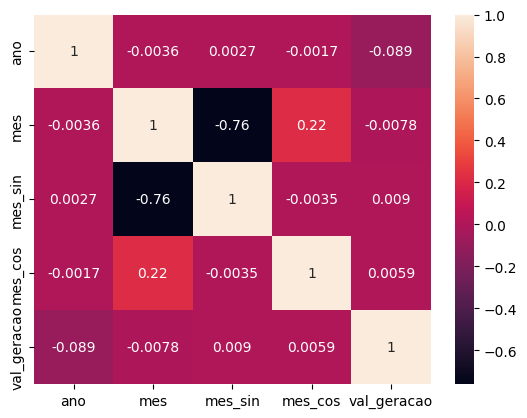

In [347]:
correlation = df4[['ano', 'mes', 'mes_sin', 'mes_cos', 'val_geracao']].corr( method='pearson' )
sns.heatmap( correlation, annot=True );

In [353]:
df_one_hot = pd.get_dummies(df4, columns=['nom_subsistema','cod_modalidadeoperacao', 'nom_tipousina'], dtype=int)

In [355]:
df_one_hot.columns

Index(['ano', 'mes', 'id_estado', 'nom_tipocombustivel', 'val_geracao',
       'mes_sin', 'mes_cos', 'nom_subsistema_NORDESTE', 'nom_subsistema_NORTE',
       'nom_subsistema_PARAGUAI', 'nom_subsistema_SUDESTE',
       'nom_subsistema_SUL', 'cod_modalidadeoperacao_Conjunto de Usinas',
       'cod_modalidadeoperacao_Pequenas Usinas (Tipo III)',
       'cod_modalidadeoperacao_TIPO I', 'cod_modalidadeoperacao_TIPO II-A',
       'cod_modalidadeoperacao_TIPO II-B', 'cod_modalidadeoperacao_TIPO II-C',
       'cod_modalidadeoperacao_TIPO III', 'nom_tipousina_BOMBEAMENTO',
       'nom_tipousina_EOLIELÉTRICA', 'nom_tipousina_FOTOVOLTAICA',
       'nom_tipousina_HIDROELÉTRICA', 'nom_tipousina_NUCLEAR',
       'nom_tipousina_TÉRMICA'],
      dtype='object')

In [356]:
df5 = df_one_hot.groupby(['ano', 'mes', 'mes_sin', 'mes_cos', 'nom_subsistema_NORDESTE', 'nom_subsistema_NORTE',
       'nom_subsistema_PARAGUAI', 'nom_subsistema_SUDESTE', 'nom_subsistema_SUL', 'cod_modalidadeoperacao_Conjunto de Usinas',
       'cod_modalidadeoperacao_Pequenas Usinas (Tipo III)','cod_modalidadeoperacao_TIPO I', 'cod_modalidadeoperacao_TIPO II-A',
       'cod_modalidadeoperacao_TIPO II-B', 'cod_modalidadeoperacao_TIPO II-C', 'cod_modalidadeoperacao_TIPO III', 'nom_tipousina_BOMBEAMENTO',
       'nom_tipousina_EOLIELÉTRICA', 'nom_tipousina_FOTOVOLTAICA','nom_tipousina_HIDROELÉTRICA', 'nom_tipousina_NUCLEAR', 'nom_tipousina_TÉRMICA']).val_geracao.sum().reset_index()

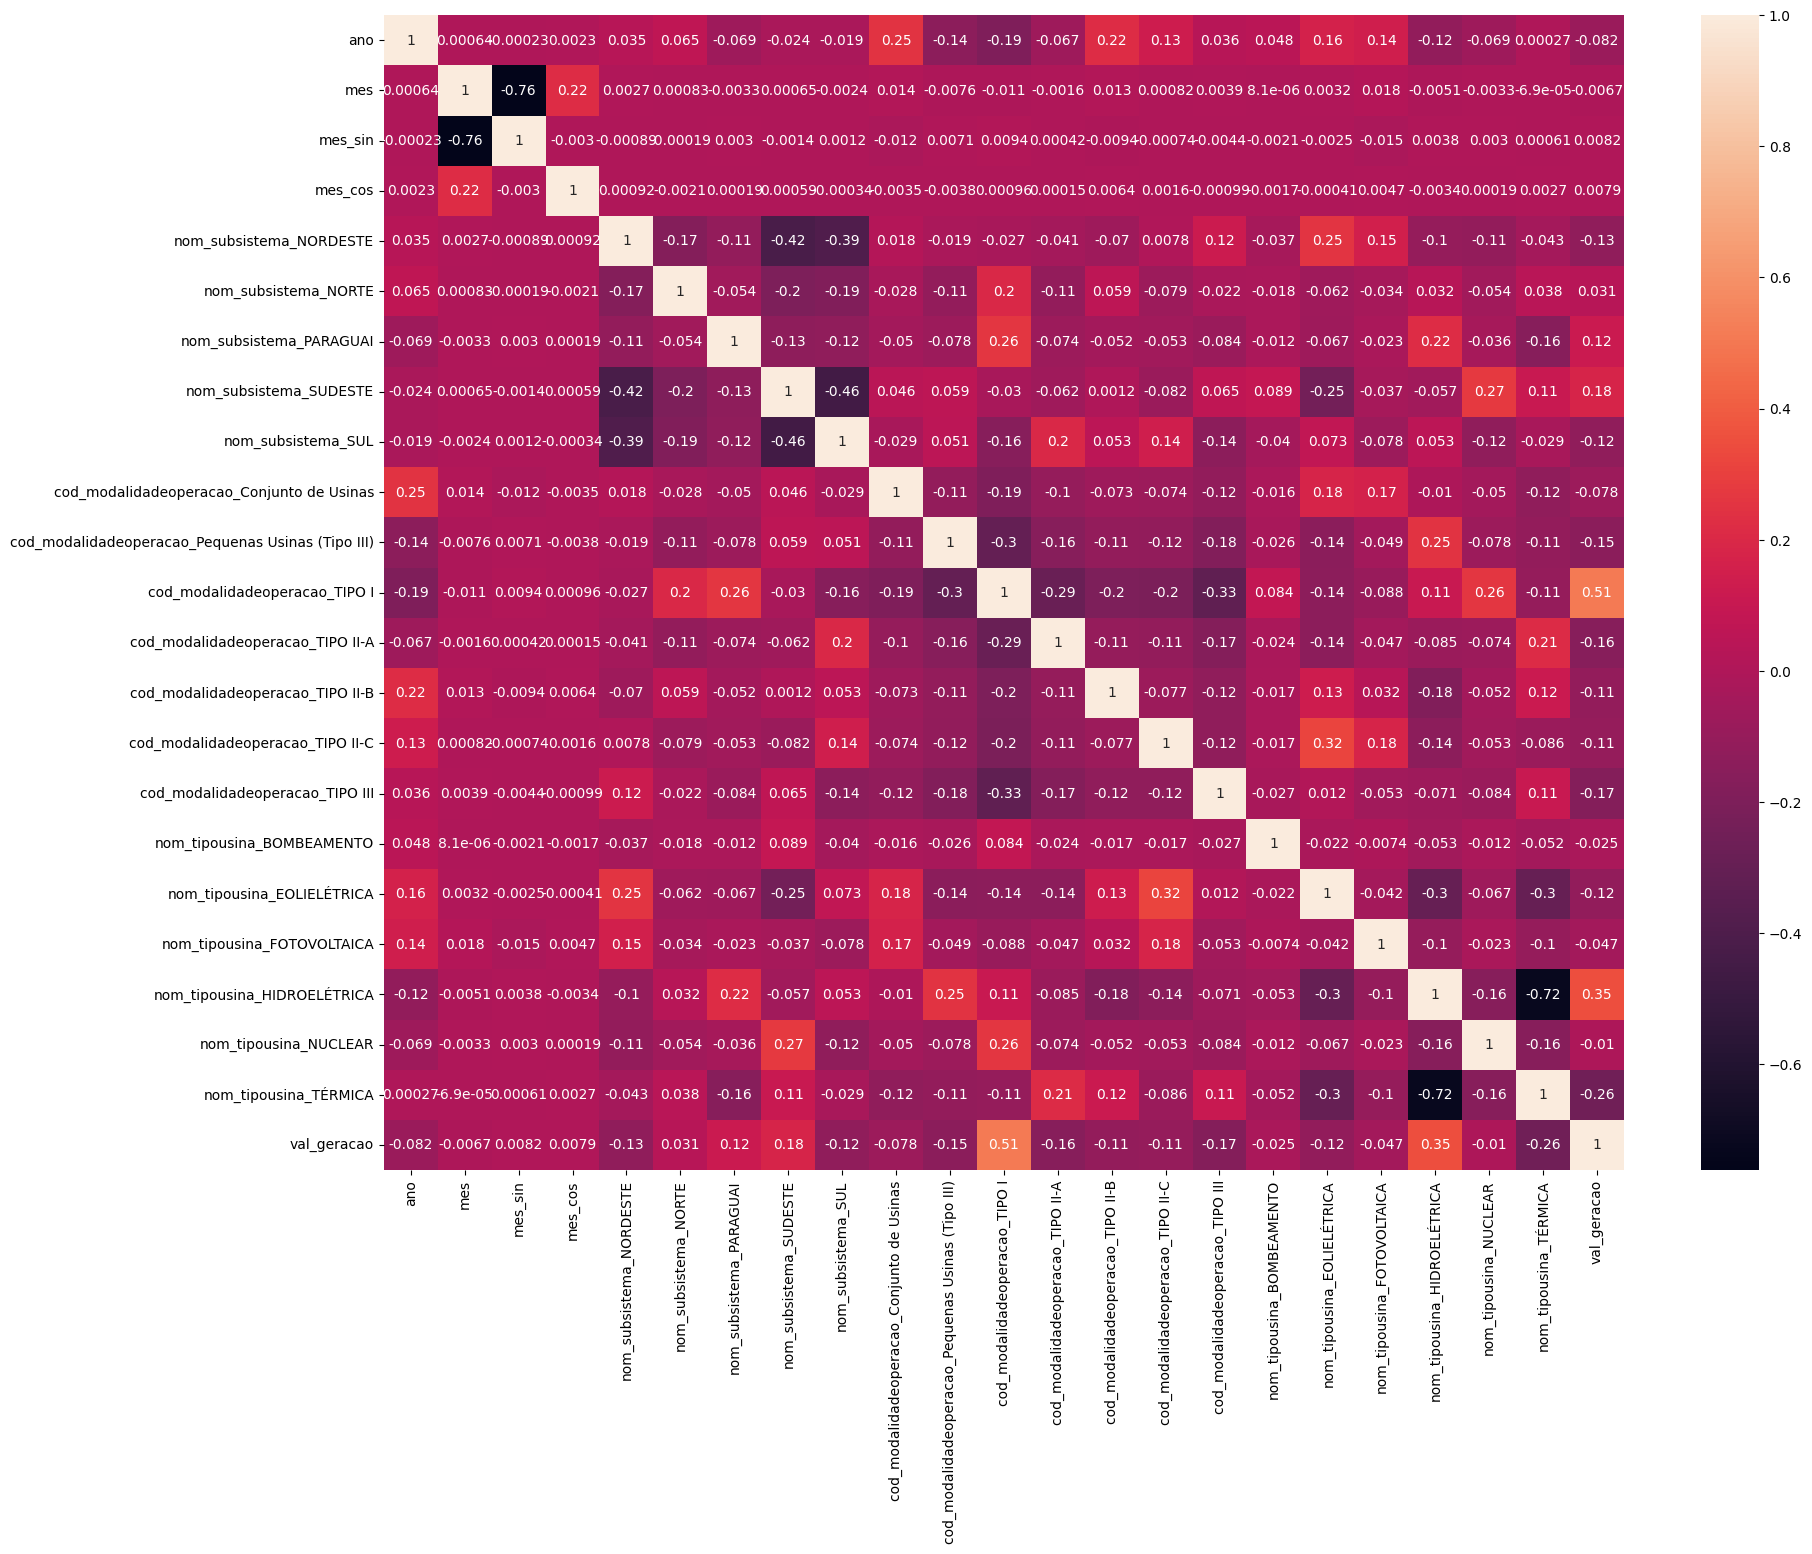

In [362]:
plt.figure(figsize=(20, 15))
correlation = df5.corr( method='pearson' )
sns.heatmap( correlation, annot=True );

# 7.0. Feature Selection

## 7.1. Train Test Split

In [365]:
df_train = df5.copy() # 2000 a 2018
df_test = df_val.copy() # 2019 a 2020

In [374]:
# Vamos preparar os dados de teste para se adequar ao nosso modelo
# Modificamos para formato de data e separamos ano e mês
df_test['din_instante'] = pd.to_datetime(df_test['din_instante'])
df_test['ano'] = df_test['din_instante'].dt.year
df_test['mes'] = df_test['din_instante'].dt.month

In [375]:
# Filtramos apenas as colunas necessárias
df_test = df_test.groupby(['ano', 'mes', 'nom_subsistema', 'cod_modalidadeoperacao', 'nom_tipousina']).agg({'val_geracao': 'sum'}).sort_values(['ano', 'mes']).reset_index()

In [376]:
# Encoding das variáveis categóricas
df_test = pd.get_dummies(df_test, columns=['nom_subsistema','cod_modalidadeoperacao', 'nom_tipousina'], dtype=int)

## 7.2. Feature selection (Correlation Based)

In [380]:
# Vamos selecionar as 10 variáveis com maior correlação com a variável alvo
correlation_matrix = df_train.corr()
feature_scores = abs(correlation_matrix['val_geracao'])
selected_features = feature_scores.nlargest(10).index
selected_features = selected_features.drop(['val_geracao'])
selected_features

Index(['cod_modalidadeoperacao_TIPO I', 'nom_tipousina_HIDROELÉTRICA',
       'nom_tipousina_TÉRMICA', 'nom_subsistema_SUDESTE',
       'cod_modalidadeoperacao_TIPO III', 'cod_modalidadeoperacao_TIPO II-A',
       'cod_modalidadeoperacao_Pequenas Usinas (Tipo III)',
       'nom_subsistema_NORDESTE', 'nom_subsistema_SUL'],
      dtype='object')

## 7.3. Criando treino e teste

In [404]:
x_train = df_train[selected_features]
y_train = df_train['val_geracao']

x_test = df_test[selected_features]
y_test = df_test['val_geracao']

In [405]:
# Vamos normalizar a variável alvo
y_train_norm = np.log1p(y_train)
y_test_norm = np.log1p(y_test)

# 8.0. Modelagem Machine Learning

## 8.1. Modelo com dados de base

### Vamos aplicar os modelos de machine learning apenas com as variáveis ano e mês para servir de base se os modelos posteriores serão melhores ou piores

In [514]:
# Pegamos df3 pois já está com dados mensais e com dados limpos
df_base = df3.copy()

In [515]:
df_base = df_base.groupby(['ano', 'mes']).val_geracao.sum().reset_index()

In [516]:
x_train_base = df_base[['ano', 'mes']]
y_train_base = df_base['val_geracao']

### 8.1.1 Regressão Linear

In [517]:
# model
lr = LinearRegression().fit( x_train_base, y_train_base )

# prediction
y_pred_lr = lr.predict( x_train_base )

# performance
lr_result = ml_error( 'Linear Regression', (y_train_base),(y_pred_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1.600267e+06,0.043917,2.153653e+06


### 8.1.2. Random Forest

In [518]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_base, y_train_base )

# prediction
y_pred_rf_base = rf.predict( x_train_base )

rf_result = ml_error('random forest', y_train_base, y_pred_rf_base)
rf_result

,Model Name,MAE,MAPE,RMSE
0,random forest,406564.016474,0.0111,562227.006035


## 8.2. Modelo com dados selecionados

### 8.2.1. Regressão Linear

In [422]:
# model
lr = LinearRegression().fit( x_train, y_train_norm )

# prediction
y_pred_lr = lr.predict( x_train )
y_pred_desnorm_lr = np.expm1(y_pred_lr)

# performance
lr_result = ml_error( 'Linear Regression', (y_train),(y_pred_desnorm_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,764861.050553,5.481797e+21,2.036828e+06


### 8.2.2. Random Forest

In [423]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train_norm )

# prediction
y_pred_rf = rf.predict( x_train )
y_pred_desnorm_rf = np.expm1(y_pred_rf)

rf_result = ml_error('random forest', y_train, y_pred_desnorm_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,random forest,365540.742436,6.767003e+20,814226.811014


### Podemos ver que os modelos com feature engineering estão semelhantes ou piores do ponto de vista do MAPE

## 8.3. Testando com diferentes variáveis

In [448]:
correlation_matrix = df_train.corr()
feature_scores = abs(correlation_matrix['val_geracao'])
selected_features = feature_scores.nlargest(5).index
selected_features = selected_features.drop(['val_geracao'])
selected_features

Index(['cod_modalidadeoperacao_TIPO I', 'nom_tipousina_HIDROELÉTRICA',
       'nom_tipousina_TÉRMICA', 'nom_subsistema_SUDESTE'],
      dtype='object')

In [449]:
x_train = df_train[selected_features]
y_train = df_train['val_geracao']

x_test = df_test[selected_features]
y_test = df_test['val_geracao']

In [450]:
y_train_norm = np.log1p(y_train)
y_test_norm = np.log1p(y_test)

### 8.2.1. Regressão Linear

In [451]:
# model
lr = LinearRegression().fit( x_train, y_train_norm )

# prediction
y_pred_lr = lr.predict( x_train )
y_pred_desnorm_lr = np.expm1(y_pred_lr)

# performance
lr_result = ml_error( 'Linear Regression', (y_train),(y_pred_desnorm_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,862308.199176,7.464279e+19,2.192986e+06


### 8.2.2. Random Forest

In [452]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train_norm )

# prediction
y_pred_rf = rf.predict( x_train )
y_pred_desnorm_rf = np.expm1(y_pred_rf)

rf_result = ml_error('random forest', y_train, y_pred_desnorm_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,random forest,403117.249005,1.012590e+19,866788.928367


### Os resultados são parecidos sendo piores do que o modelo de base

## 8.3. Criando variáveis para o modelo de base

In [454]:
df_base['mes_sin'] = np.sin(2 * np.pi * df4['mes']/12)
df_base['mes_cos'] = np.cos(2 * np.pi * df4['mes']/12)

In [455]:
x_train_base = df_base[['ano', 'mes_sin', 'mes_cos']]
y_train_base = df_base['val_geracao']

### 8.3.1 Regressão Linear

In [456]:
# model
lr = LinearRegression().fit( x_train_base, y_train_base )

# prediction
y_pred_lr = lr.predict( x_train_base )

# performance
lr_result = ml_error( 'Linear Regression', (y_train_base),(y_pred_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1.459811e+06,0.040237,2.009316e+06


### 8.3.2. Random Forest

In [457]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train_base, y_train_base )

# prediction
y_pred_rf = rf.predict( x_train_base )

rf_result = ml_error('random forest', y_train_base, y_pred_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,random forest,1.314256e+06,0.03549,1.827395e+06


### Como o modelo de base continua praticamente melhor vamos continuar com essa base para a criar os modelos

## 8.4. Comparação de modelos ML

### 8.4.1. Preparando os dados definitivos

In [467]:
df_test = df_val.copy()

In [468]:
# Vamos preparar os dados de teste para se adequar ao nosso modelo
# Modificamos para formato de data e separamos ano e mês
df_test['din_instante'] = pd.to_datetime(df_test['din_instante'])
df_test['ano'] = df_test['din_instante'].dt.year
df_test['mes'] = df_test['din_instante'].dt.month

In [469]:
# Filtramos apenas as colunas necessárias
df_test = df_test.groupby(['ano', 'mes']).agg({'val_geracao': 'sum'}).sort_values(['ano', 'mes']).reset_index()

In [470]:
x_train = df_base[['ano', 'mes']]
y_train = df_base['val_geracao']

x_test = df_test[['ano', 'mes']]
y_test = df_test['val_geracao']

### 8.4.2 Regressão Linear

In [472]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
y_pred_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', (y_test),(y_pred_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,3.183868e+06,0.071597,4.090584e+06


### 8.4.3. Random Forest

In [520]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
y_pred_rf = rf.predict( x_test)

rf_result = ml_error('random forest', y_test, y_pred_rf)
rf_result

,Model Name,MAE,MAPE,RMSE
0,random forest,1.430595e+06,0.030852,1.855479e+06


### 8.4.4. XGBoost

In [471]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.1, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytree=0.9 ).fit( x_train, y_train )

# prediction
y_pred_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, y_pred_xgb)
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1.879300e+06,0.040161,2.322581e+06


In [489]:
modelling_result = pd.concat( [lr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,random forest,1.430595e+06,0.030852,1.855479e+06
0,XGBoost Regressor,1.879300e+06,0.040161,2.322581e+06
0,Linear Regression,3.183868e+06,0.071597,4.090584e+06


# 9.0. Hyperparameter Fine Turing

In [498]:
#Random Search
param = {
    'n_estimators': [1000, 1500, 2000],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}
MAX_EVAL = 5

In [499]:
final_result_rf = pd.DataFrame()

for i in range(MAX_EVAL):
    # Choose values for parameters randomly
    hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
    print(hp)

    # Model
    model_rf = RandomForestRegressor(n_estimators=hp['n_estimators'],
                                     max_depth=hp['max_depth'],
                                     min_samples_split=hp['min_samples_split'],
                                     min_samples_leaf=hp['min_samples_leaf'],
                                     max_features=hp['max_features']).fit( x_train, y_train )
    y_pred_rf = rf.predict( x_test)

    # Performance
    result_rf =  ml_error('random forest', y_test, y_pred_rf)
    final_result_rf = pd.concat([final_result_rf, result_rf])

final_result_rf

{'n_estimators': 1000, 'max_depth': 5, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
{'n_estimators': 2000, 'max_depth': None, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
{'n_estimators': 1500, 'max_depth': 10, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt'}
{'n_estimators': 1500, 'max_depth': 15, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2'}
{'n_estimators': 1500, 'max_depth': None, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'log2'}


,Model Name,MAE,MAPE,RMSE
0,random forest,1.430595e+06,0.030852,1.855479e+06
0,random forest,1.430595e+06,0.030852,1.855479e+06
0,random forest,1.430595e+06,0.030852,1.855479e+06
0,random forest,1.430595e+06,0.030852,1.855479e+06
0,random forest,1.430595e+06,0.030852,1.855479e+06


### Como todos os valores foram iguais vamos utilizar o primeiro com que fizemos na seção 8.4.3 

## 9.1. Feature importance

In [501]:
feature_importance = rf.feature_importances_
feature_importance

array([0.93622226, 0.06377774])

## A variável mais importante é a variável Ano

# 10. Comparação gráfica

In [521]:
df_base['pred'] = y_pred_rf_base
df_test['pred'] = y_pred_rf

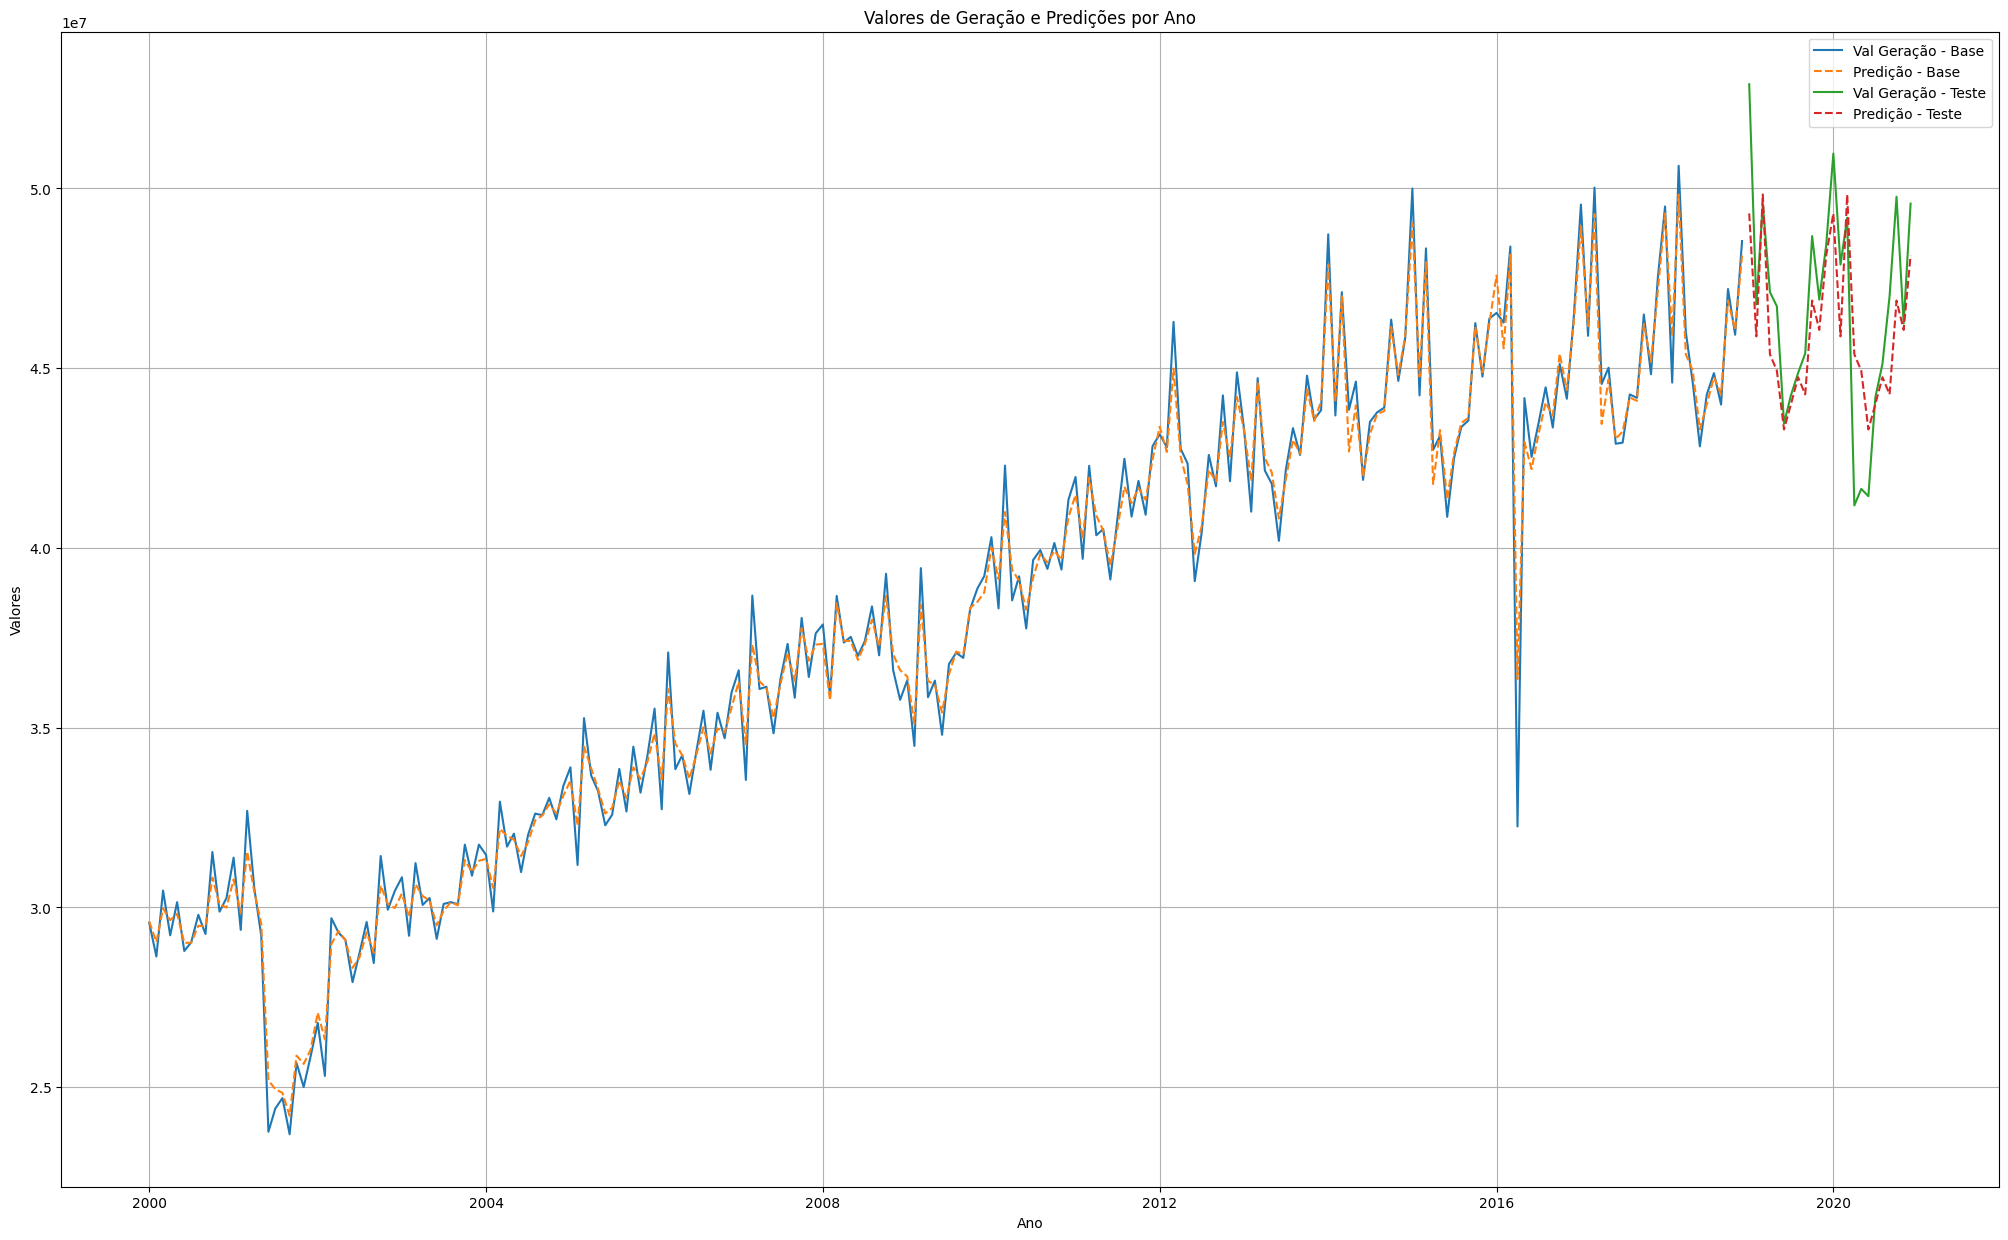

In [541]:
# Assegurando que os DataFrames estão ordenados por ano
df_base['data'] = pd.to_datetime({'year': df_base['ano'], 'month': df_base['mes'], 'day': 1})
df_test['data'] = pd.to_datetime({'year': df_test['ano'], 'month': df_test['mes'], 'day': 1})

# Ordenando o dataframe por data
df_base = df_base.sort_values(by='data')
df_test = df_test.sort_values(by='data')

# Criando o gráfico
plt.figure(figsize=(25, 15))  # Ajuste o tamanho conforme necessário

# Plotando os valores de geração e predições para df_base
plt.plot(df_base['data'], df_base['val_geracao'], label='Val Geração - Base')
plt.plot(df_base['data'], df_base['pred'], label='Predição - Base', linestyle='--')

# Plotando os valores de geração e predições para df_test
plt.plot(df_test['data'], df_test['val_geracao'], label='Val Geração - Teste')
plt.plot(df_test['data'], df_test['pred'], label='Predição - Teste', linestyle='--')

# Adicionando títulos e legendas
plt.title('Valores de Geração e Predições por Ano')
plt.xlabel('Ano')
plt.ylabel('Valores')
plt.legend()
plt.grid(True)

# Mostrando o gráfico
plt.show()

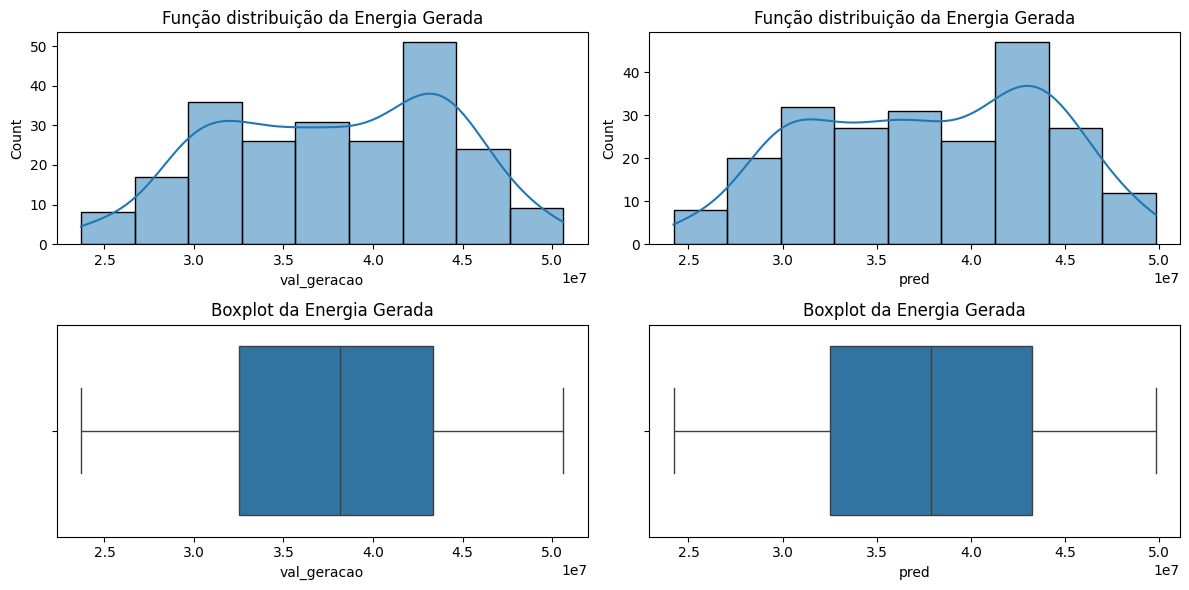

In [545]:
# Vamos analisar o gráfico de distribuição da energia 
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot a distribution plot on the first subplot
sns.histplot(df_base.val_geracao, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Função distribuição da Energia Gerada')

# Plot a box plot on the second subplot
sns.boxplot(x=df_base.val_geracao, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot da Energia Gerada')

# Plot a distribution plot on the third subplot
sns.histplot(df_base.pred, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Função distribuição da Energia Gerada')

# Plot a box plot on the fourth subplot
sns.boxplot(x=df_base.pred, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot da Energia Gerada')

plt.tight_layout() # Adjust the layout to make sure there's no overlap
plt.show()

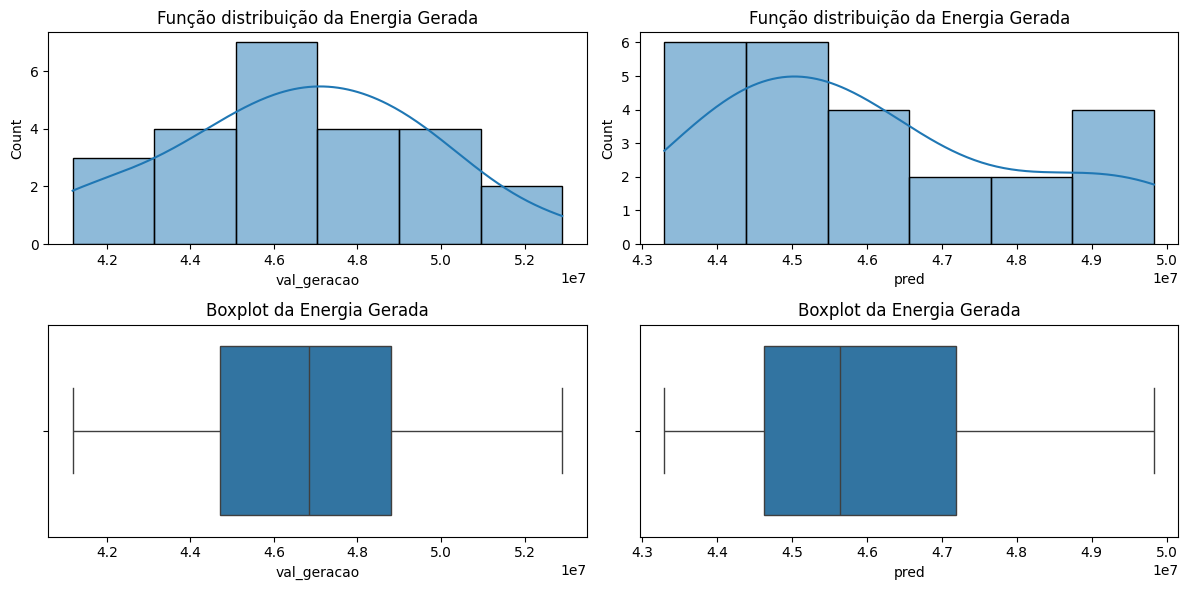

In [546]:
# Vamos analisar o gráfico de distribuição da energia 
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot a distribution plot on the first subplot
sns.histplot(df_test.val_geracao, ax=axes[0, 0], kde=True)
axes[0, 0].set_title('Função distribuição da Energia Gerada')

# Plot a box plot on the second subplot
sns.boxplot(x=df_test.val_geracao, ax=axes[1, 0])
axes[1, 0].set_title('Boxplot da Energia Gerada')

# Plot a distribution plot on the third subplot
sns.histplot(df_test.pred, ax=axes[0, 1], kde=True)
axes[0, 1].set_title('Função distribuição da Energia Gerada')

# Plot a box plot on the fourth subplot
sns.boxplot(x=df_test.pred, ax=axes[1, 1])
axes[1, 1].set_title('Boxplot da Energia Gerada')

plt.tight_layout() # Adjust the layout to make sure there's no overlap
plt.show()

